In [1]:
%pylab inline 
%config Completer.use_jedi = False

Populating the interactive namespace from numpy and matplotlib


In [2]:
# %pip install flatbuffers

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

import matplotlib.pyplot as plt
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

2022-07-13 20:05:06.324787: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-07-13 20:05:09.427561: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-13 20:05:09.429848: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-13 20:05:09.445645: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:73:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.62GiB deviceMemoryBandwidth: 625.94GiB/s
2022-07-13 20:05:09.445715: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-07-13 20:05:09.453535: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-0

In [5]:
sys.path.append('../../normalizing_flows/src/')
import flows

sys.path.append('../src/')
import bbvi
from mf_gaussian import MF_Gaussian
import polyakvi 

2022-07-13 20:05:10.403164: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-13 20:05:10.406349: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-13 20:05:10.407068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:73:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.62GiB deviceMemoryBandwidth: 625.94GiB/s
2022-07-13 20:05:10.407262: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-07-13 20:05:10.407307: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Succ

# PosteriorDB example

In [6]:
from posteriordb import PosteriorDatabase
import os
pdb_path = os.path.join('../../posteriordb/posterior_database/')
my_pdb = PosteriorDatabase(pdb_path)
pos = my_pdb.posterior_names()




In [71]:
posterior.name

'kidiq_with_mom_work-kidscore_interaction_c'

In [7]:

posterior = my_pdb.posterior(pos[1])
D = 5
# posterior = my_pdb.posterior(pos[5])
# D = 4
posname = posterior.name
refdrawsdict = posterior.reference_draws()
stanmodel, data = posterior.model, posterior.data.values()
refinfo = posterior.reference_draws_info()
refdrawsdict = posterior.reference_draws()
keys = refdrawsdict[0].keys()
stansamples = []
for key in keys:
    stansamples.append(np.array([refdrawsdict[i][key] for i in range(len(refdrawsdict))]).flatten())
print(stanmodel.code('stan'))


data {
  int<lower=0> N;
  vector[N] kid_score;
  vector[N] mom_hs;
  vector[N] mom_iq;
}
transformed data {           // centered predictors
  vector[N] c_mom_hs;
  vector[N] c_mom_iq;
  vector[N] inter;
  c_mom_hs = mom_hs - mean(mom_hs);
  c_mom_iq = mom_iq - mean(mom_iq);
  inter    = c_mom_hs .* c_mom_iq;
}
parameters {
  vector[4] beta;
  real<lower=0> sigma;
}
model {
  kid_score ~ normal(beta[1] + beta[2] * c_mom_hs + beta[3] * c_mom_iq
                     + beta[4] * inter, sigma);
}



<Figure size 460.8x576 with 0 Axes>

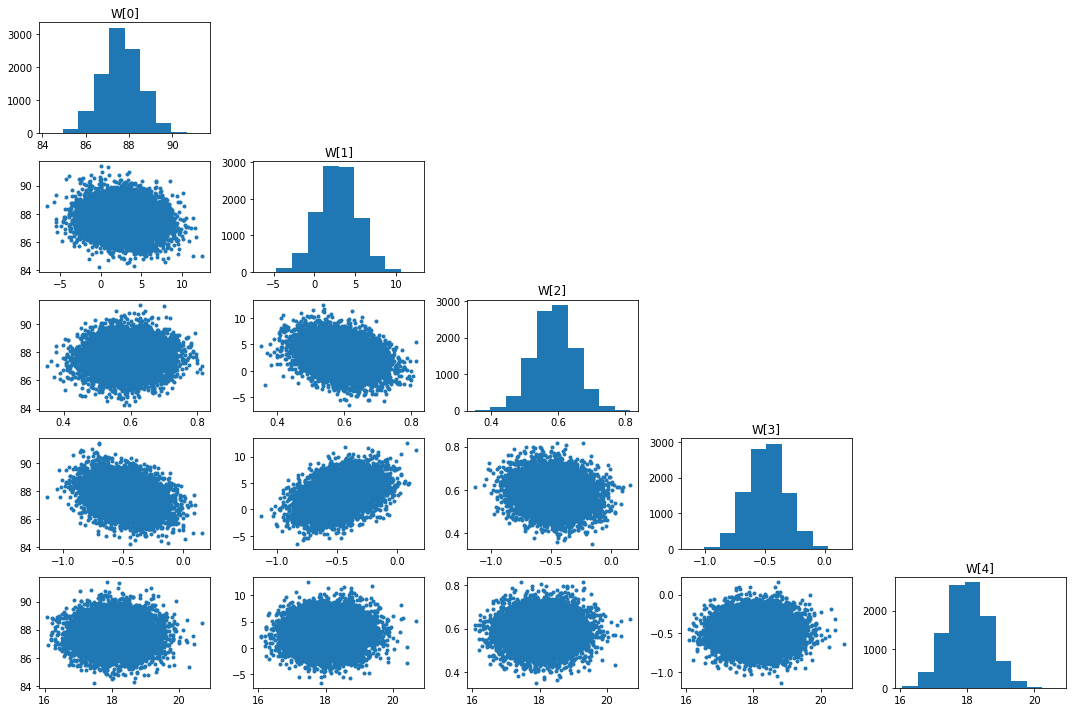

In [8]:
fig = plt.figure()
fig.set_size_inches(6.4, 8)

# Plot weight posteriors
# for i in range(D):
#     plt.subplot(D+1, 1, i+1)
#     plt.hist(stansamples[i], density = True)
#     plt.title('W[{}]'.format(i))
fig, ax = plt.subplots(D, D, figsize=(3*D, 2*D))

for i in range(D):
    for j in range(D):
        if i==j:
            ax[i, j].hist(stansamples[i])
            ax[i, j].set_title('W[{}]'.format(i))
        elif i>j:
            ax[i, j].plot(stansamples[i], stansamples[j], '.')
        else:
            ax[i, j].axis('off')

plt.tight_layout()
plt.show()


In [9]:
#Transfomrm
hs = np.array(data['mom_hs'])- np.mean(data['mom_hs'])
iq = np.array(data['mom_iq'])- np.mean(data['mom_iq'])
inter = hs*iq
yv = np.array(data['kid_score'], dtype=np.float32)

samples = np.array(stansamples).copy()
# samples[0] -= yv.mean()
# yv = yv - yv.mean()



@tf.function
def loglik(w):
    w0, w1, w2, w3, logsigma = tf.split(w, D, 1)
    mu = w0 + w1*hs + w2*iq + w3*inter + 88
#     sigma = tf.nn.softplus(logsigma)
    sigma = tf.exp(logsigma)
    ll = tfd.Normal(mu, sigma).log_prob(yv)
    return tf.reduce_sum(ll, axis=1)


def gensamples(model, n=1000):
    samples = model.sample(n).numpy().T
    samples[-1] = tf.exp(samples[-1])
    samples[0] += 88
    return samples


# ##Transfomrm
# earn = np.log(data['earn']) 
# height = np.log(data['height']) 
# male = np.array(data['male'])
# samples = np.array(stansamples).copy()
# # samples[0] -= yv.mean()
# # yv = yv - yv.mean()
# @tf.function
# def loglik(w):
#     mu = w[0] + w[1]*height + w[2]*male
#     sigma = tf.exp(w[-1])
#     ll = tfd.Normal(mu, sigma).log_prob(earn)
#     return ll

# Mean field VI

In [72]:
model = MF_Gaussian(D) #VImeanfield(x0)
model.trainable_variables;
loglik(model.sample(32))
bbvi.bbvi_elbo(model, loglik);

creating graph
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


0
100
200
300
400
500
600
700
800
900


/tmp/ipykernel_1457940/1313407627.py:13: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.semilogy()


[]

/mnt/home/cmodi/miniconda3/envs/defpyn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


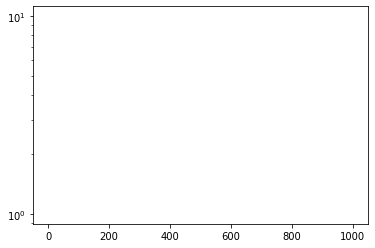

In [73]:
# Fit the model
opt = tf.keras.optimizers.Adam(lr=0.001)

losses = []
for epoch in range(1000):
    if epoch %100 == 0: print(epoch)
    elbo, grads = bbvi.bbvi_elbo(model, loglik)
#     elbo, grads = bbvi.bbvi_reparam(model, loglik2)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    losses.append(elbo)

plt.plot(losses)
plt.semilogy()


In [74]:
qsamples = gensamples(model)
# qsamples = model.sample(1000).numpy().T
# qsamples[-1] = tf.exp(qsamples[-1])
# qsamples[0] += 88

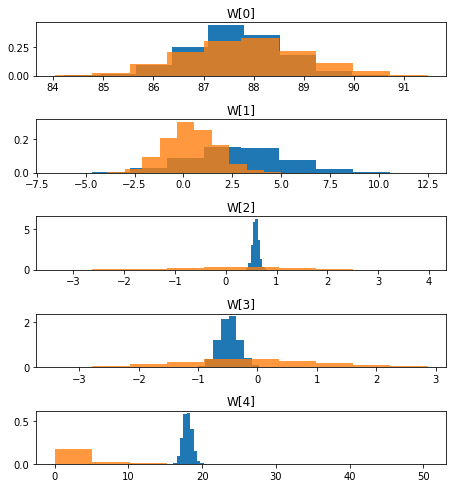

In [75]:
fig = plt.figure()
fig.set_size_inches(6.4, 8)

# Plot weight posteriors
for i in range(D):
    plt.subplot(D+1, 1, i+1)
    if i == 0: plt.hist(samples[i], density = True)
    else: plt.hist(samples[i], density = True)
    plt.hist(qsamples[i], density = True, alpha=0.8)
    plt.title('W[{}]'.format(i))
    

plt.tight_layout()
plt.show()


# Verify overparameterization

In [53]:
flowcheck = flows.MAFFlow(5, nlayers=5)
x0 = np.random.random(D).reshape(1, D)
flowcheck(x0)
len(flowcheck.trainable_variables), len(flowcheck.flow.trainable_variables)

@tf.function
def fvi(model, x):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        logp = -tf.reduce_mean(model.log_prob(x), axis=0)
    gradients = tape.gradient(logp, model.trainable_variables)
    return logp, gradients



0
1
2
3
4
Built


In [54]:
len(flowcheck.bijector.bijectors)

12

In [55]:
samplest = samples.copy().astype(np.float32)
samplest[0] -= 88
samplest[-1] = np.log(samplest[-1])
samplest = samplest.T
# samplest = tf.constant(samplest.T)

In [56]:
5//2

2

In [57]:
fvi(flowcheck, samplest[1:5]);

# Fit the model
opt = tf.keras.optimizers.Adam(lr=0.001)

lps = []
for epoch in range(1000):
    if epoch %100 == 0: print(epoch)
    idx = np.random.randint(0, samples.shape[1], 32)
    lp, grads = fvi(flowcheck, tf.constant(samplest[idx]))
    opt.apply_gradients(zip(grads, flowcheck.trainable_variables))
    lps.append(lp)



0
100
200
300
400
500
600
700
800
900


[]

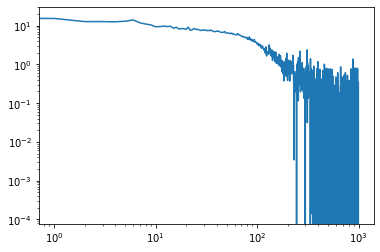

In [58]:
plt.plot(lps)
plt.loglog()

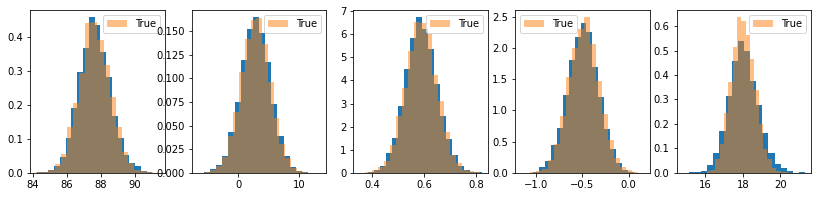

In [59]:
ss = gensamples(flowcheck, 10000)

fig, ax = plt.subplots(1, D, figsize=(14, 3))
for i in range(D):
    ax[i].hist(ss[i], density=True, bins=20)
    ax[i].hist(samples[i], alpha=0.5, density=True, bins=20, label=True) 
    ax[i].legend() 

(array([4.63347573e-02, 2.80735942e-01, 1.83432320e+00, 6.24428994e+00,
        9.30238393e+00, 6.63954131e+00, 2.35763680e+00, 4.85152165e-01,
        5.72370532e-02, 8.17677502e-03]),
 array([2.723705 , 2.7603946, 2.7970839, 2.8337731, 2.8704627, 2.9071522,
        2.9438415, 2.9805307, 3.0172203, 3.0539098, 3.090599 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

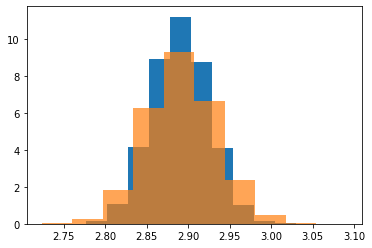

In [60]:
plt.hist(samplest[:, -1], density=True)
plt.hist(flowcheck.sample(10000).numpy()[:, -1], density=True, alpha=0.7)

# Flow


0
1
2
3
4
Built


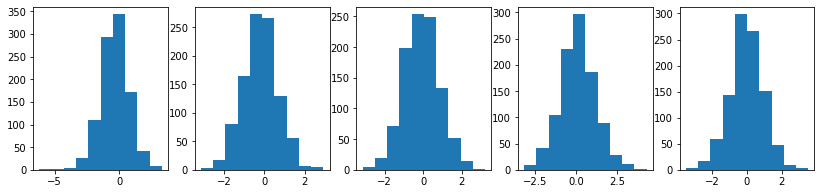

In [58]:
flow = flows.MAFFlow(5, nlayers=5)
x0 = np.random.random(D).reshape(1, D)
flow(x0)
len(flow.trainable_variables), len(flow.flow.trainable_variables)

x0 = flow.sample(1000).numpy()
fig, ax = plt.subplots(1, D, figsize=(14, 3))
[ax[i].hist(x0[:, i]) for i in range(D)];

In [59]:
# Fit the model
opt = tf.keras.optimizers.Adam(lr=0.01)

elbos = []
for epoch in range(2000):
    if epoch %500 == 0: print(epoch)
    elbo, grads = bbvi.bbvi_elbo(flow, loglik)
    if np.isnan(elbo):
            print("NaNs!!! :: ", epoch, elbo)
            break

#     elbo, grads = bbvi.bbvi_reparam(flow, loglik2)
    opt.apply_gradients(zip(grads, flow.trainable_variables))
    elbos.append(elbo)
    if (epoch %100 == 0):
        print("Elbo at epoch %d is"%epoch, elbo)
        

0
creating graph
Elbo at epoch 0 is tf.Tensor(-683010.0, shape=(), dtype=float32)
Elbo at epoch 100 is tf.Tensor(-1882.9945, shape=(), dtype=float32)
Elbo at epoch 200 is tf.Tensor(-1881.7937, shape=(), dtype=float32)
Elbo at epoch 300 is tf.Tensor(-1877.9822, shape=(), dtype=float32)
Elbo at epoch 400 is tf.Tensor(-1876.8075, shape=(), dtype=float32)
500
Elbo at epoch 500 is tf.Tensor(-1875.7292, shape=(), dtype=float32)
Elbo at epoch 600 is tf.Tensor(-1875.2008, shape=(), dtype=float32)
Elbo at epoch 700 is tf.Tensor(-1874.5741, shape=(), dtype=float32)
Elbo at epoch 800 is tf.Tensor(-1875.3127, shape=(), dtype=float32)
Elbo at epoch 900 is tf.Tensor(-1874.4712, shape=(), dtype=float32)
1000
Elbo at epoch 1000 is tf.Tensor(-1874.4978, shape=(), dtype=float32)
Elbo at epoch 1100 is tf.Tensor(-1873.9832, shape=(), dtype=float32)
Elbo at epoch 1200 is tf.Tensor(-1873.7836, shape=(), dtype=float32)
Elbo at epoch 1300 is tf.Tensor(-1873.894, shape=(), dtype=float32)
Elbo at epoch 1400 is 

[]

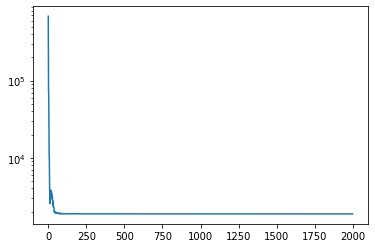

In [60]:
plt.figure()
plt.plot(-np.array(elbos))
plt.semilogy()


In [61]:
flowsamples = gensamples(flow)

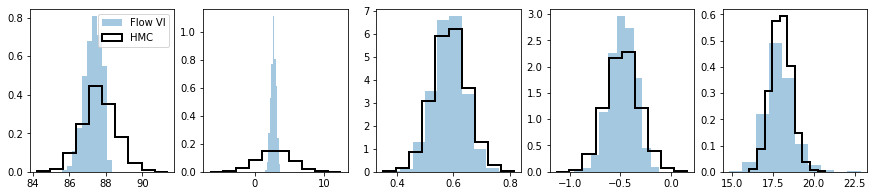

In [62]:
fig, ax = plt.subplots(1, D, figsize=(15, 3))
for ii in range(D):
    ax[ii].hist(flowsamples[ii], density=True, alpha=0.4, label='Flow VI');
#     ax[ii].hist(qsamples[ii], density=True, alpha=0.4, label='VI');
    ax[ii].hist(samples[ii], density=True, alpha=1, lw=2, histtype='step', color='k', label='HMC');
ax[0].legend()

In [ ]:
tf.gradients()

In [68]:
grads;

In [69]:
flow.trainable_variables;

# Polyak VI 

In [15]:
import polyakvi

In [16]:
# newrun = 0

# if newrun:
#     flowp = flows.MAFFlow(5, nlayers=5)
# #     flowp = MF_Gaussian(D)
#     x0 = np.random.random(D).reshape(1, D)
#     flowp(x0)
#     (len(flowp.trainable_variables))
# else:
#     pass

# opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.)
# polyelbos = []
# epss = []
# losses = []
# for epoch in range(1001):
#     elbo, loss, grads = polyakvi.polyakvi(flowp, loglik, nsamples=1)
#     elbo, loss = elbo.numpy(), loss.numpy()
#     #
#     gradnorm = (tf.linalg.global_norm(grads)).numpy()
#     eps = 0.9*loss/gradnorm**2
#     eps = min(1e-4, abs(eps))
#     eps *= np.sign(loss)
# #     print(eps)
#     if np.isnan(eps):
#         print(epoch, eps, loss, gradnorm)
#         break
#     opt.learning_rate = eps
#     opt.apply_gradients(zip(grads, flowp.trainable_variables))

#     epss.append(eps)
#     losses.append(loss)
#     polyelbos.append(elbo)
#     if epoch %100 == 0: 
#         print("Elbo at epoch %d is"%epoch, elbo)
#         print("Eps, loss, gradnorm are : ", eps, loss, gradnorm)
        


In [17]:
newrun = 1

if newrun:
    print("Refreshing the model\n")
    flowp = flows.MAFFlow(5, nlayers=5)
    x0 = np.random.random(D).reshape(1, D)
    flowp(x0)
    (len(flowp.trainable_variables))
else:
    print("Using earlier model and continue training\n")
    pass

flowp, losses, polyelbos, epss = polyakvi.train(flowp, loglik, mode='full', nsamples=32, epsmax=1e-2, niter=5001, nprint=500)


Refreshing the model

0
1
2
3
4
Built
Elbo at epoch 0 is -1268154.2
Eps, loss, gradnorm are :  -6.2927662116097764e-09 -173584.44 4982598.0
Elbo at epoch 500 is -3749.6797
Eps, loss, gradnorm are :  0.0004694956858323482 0.94023895 42.454582
Elbo at epoch 1000 is -3744.6465
Eps, loss, gradnorm are :  4.5273833502831314e-05 0.029872894 24.36892
Elbo at epoch 1500 is -3746.3313
Eps, loss, gradnorm are :  0.00015874882863908677 0.3611374 45.248295
Elbo at epoch 2000 is -3744.3237
Eps, loss, gradnorm are :  0.0004736401319706661 0.3050537 24.076046
Elbo at epoch 2500 is -3744.6538
Eps, loss, gradnorm are :  0.00010937178946392375 0.11771774 31.12358
Elbo at epoch 3000 is -3744.5498
Eps, loss, gradnorm are :  -0.00036571964042644823 -0.26800537 25.68141
Elbo at epoch 3500 is -3744.4033
Eps, loss, gradnorm are :  0.0005404023837815195 0.5184212 29.383532
Elbo at epoch 4000 is -3744.92
Eps, loss, gradnorm are :  -0.0001581421335972347 -0.12295914 26.453178
Elbo at epoch 4500 is -3744.291
Eps,

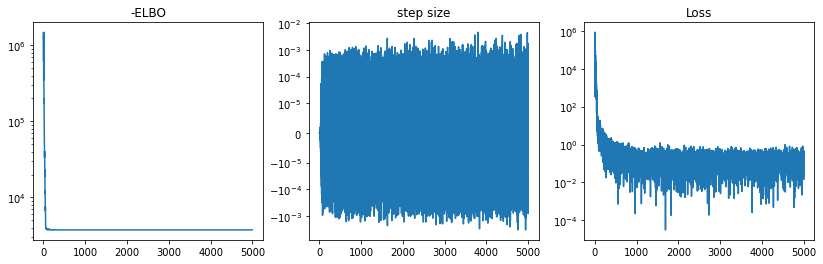

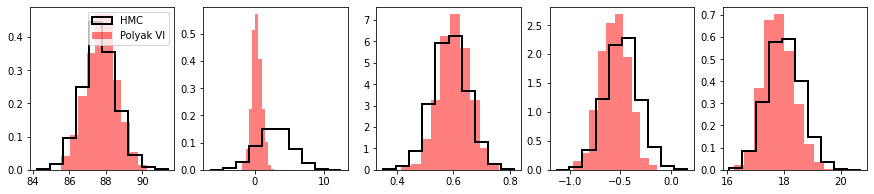

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

ax[0].plot(-polyelbos)
ax[0].semilogy()
ax[0].set_title('-ELBO')
ax[1].plot(epss)
ax[1].set_yscale('symlog', linthresh=1e-5)
ax[1].set_title('step size')
ax[2].plot(abs(losses))
ax[2].semilogy()
ax[2].set_title('Loss')
plt.show()


##########
flowpsamples = gensamples(flowp)

fig, ax = plt.subplots(1, D, figsize=(15, 3))
for ii in range(D):
    ax[ii].hist(samples[ii], density=True, alpha=1, lw=2, histtype='step', color='k', label='HMC');
#     ax[ii].hist(flowsamples[ii], density=True, alpha=0.5, label='BBVI');
#     ax[ii].hist(qsamples[ii], density=True, alpha=0.5, label='Mean field VI');
    ax[ii].hist(flowpsamples[ii], density=True, alpha=0.5, label='Polyak VI', color='red');
#   
ax[0].legend()

# Polyak 2

In [19]:
newrun = 1

if newrun:
    print("Refreshing the model\n")
    flowp2 = flows.MAFFlow(5, nlayers=5)
    x0 = np.random.random(D).reshape(1, D)
    flowp2(x0)
    (len(flowp2.trainable_variables))
else:
    print("Using earlier model and continue training\n")
    pass

# flowp2, losses2, polyelbos2, epss2 = polyakvi.train(flowp2, loglik, mode='qonly', nsamples=32, epsmax=1e-4)
flowp2, losses2, polyelbos2, epss2 = polyakvi.train(flowp2, loglik, mode='score', nsamples=32, epsmax=1e-2, niter=5001, nprint=500)



Refreshing the model

0
1
2
3
4
Built
Elbo at epoch 0 is -4798414.5
Eps, loss, gradnorm are :  0.01 1256991.9 3.7091634
Elbo at epoch 500 is -3813.5603
Eps, loss, gradnorm are :  0.01 1.0549965 8.916214
Elbo at epoch 1000 is -3744.4717
Eps, loss, gradnorm are :  -9.447186392764149e-05 -0.389122 60.885365
Elbo at epoch 1500 is -3742.5483
Eps, loss, gradnorm are :  0.00015666252611206912 0.22168732 35.686924
Elbo at epoch 2000 is -3742.394
Eps, loss, gradnorm are :  0.0009758549259824264 0.42863846 19.882647
Elbo at epoch 2500 is -3741.576
Eps, loss, gradnorm are :  6.394060823990296e-05 0.03647232 22.657635
Elbo at epoch 3000 is -3741.3801
Eps, loss, gradnorm are :  0.00038673949859595807 0.30187988 26.505077
Elbo at epoch 3500 is -3741.2478
Eps, loss, gradnorm are :  4.858221170184524e-05 0.014587402 16.438856
Elbo at epoch 4000 is -3741.1938
Eps, loss, gradnorm are :  0.00036502789878245767 0.2557373 25.110495
Elbo at epoch 4500 is -3741.3252
Eps, loss, gradnorm are :  3.4556822389340

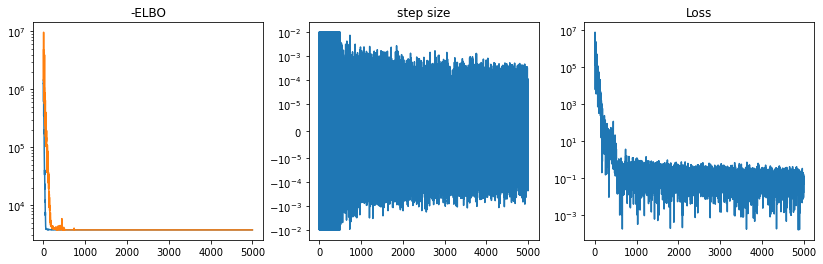

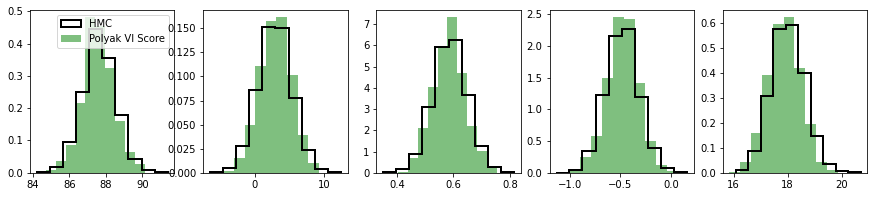

In [20]:
##################
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

try: ax[0].plot(-polyelbos)
except: pass
ax[0].plot(-polyelbos2)
ax[0].semilogy()
ax[0].set_title('-ELBO')
ax[1].plot(epss2)
ax[1].set_yscale('symlog', linthresh=1e-5)
ax[1].set_title('step size')
ax[2].plot(abs(losses2))
ax[2].semilogy()
ax[2].set_title('Loss')
plt.show()

##################
flowpsamples2 = gensamples(flowp2)
fig, ax = plt.subplots(1, D, figsize=(15, 3))
for ii in range(D):
    ax[ii].hist(samples[ii], density=True, alpha=1, lw=2, histtype='step', color='k', label='HMC');
#     ax[ii].hist(flowsamples[ii], density=True, alpha=0.5, label='BBVI');
#     ax[ii].hist(qsamples[ii], density=True, alpha=0.5, label='Mean field VI');
#     ax[ii].hist(flowpsamples[ii], density=True, alpha=0.5, label='Polyak VI', color='red');
    ax[ii].hist(flowpsamples2[ii], density=True, alpha=0.5, label='Polyak VI Score', color='green');
#   
ax[0].legend()

In [21]:
# flowp2 = flows.MAFFlow(5, nlayers=5)
# x0 = np.random.random(D).reshape(1, D)
# flowp2(x0)


# opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.)
# polyelbos2 = []
# epss2 = []
# losses2 = []
# for epoch in range(1001):
#     elbo, loss, grads = polyakvi.polyakvi_score(flowp2, loglik, nsamples=1)
#     gradnorm = (tf.linalg.global_norm(grads))
#     eps = 0.3*loss/gradnorm**2
#     eps = min(1e-4, abs(eps))
#     eps *= np.sign(loss)
    
#     opt.learning_rate = eps
#     opt.apply_gradients(zip(grads, flowp2.trainable_variables))
#     epss2.append(eps)
#     polyelbos2.append(elbo)
#     losses2.append(loss)
#     if epoch %100 == 0: print("Elbo at epoch %d is"%epoch, elbo)


# Check that it works for a simple Gaussian

<tf.Tensor: shape=(), dtype=float32, numpy=-3.3055506>

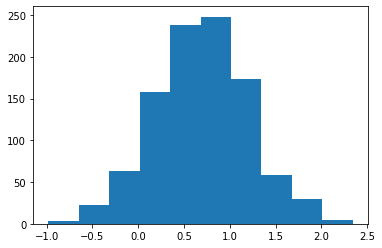

In [18]:
mu0, sig0 = np.float32(0.7), np.float32(0.5)
x0 = tf.constant(np.random.normal(mu0, sig0, 1000))
plt.hist(x0.numpy())

def loglik(w):
#     mu, sig = tf.split(w, 2, 1)
#     sig = tf.nn.softplus(sig)
    loglik = tfd.Normal(mu0, sig0).log_prob(w)
    return tf.reduce_sum(loglik, axis=0)


w = tf.constant(np.random.uniform(0, 1, 6).astype(np.float32))
loglik(w)

In [66]:
model = MF_Gaussian(1) #VImeanfield(x0)
print(model.trainable_variables)
loglik(model.sample(32))

bbvi.bbvi_elbo(model, loglik);


(<tf.Variable 'w_loc:0' shape=(1,) dtype=float32, numpy=array([-0.26513857], dtype=float32)>, <tf.Variable 'w_std:0' shape=(1,) dtype=float32, numpy=array([-0.27057245], dtype=float32)>)
creating graph


In [67]:
# Fit the model
opt = tf.keras.optimizers.Adam(lr=0.001)

# losses = []
# for epoch in range(5000):
#     if epoch %500 == 0: print(epoch)
#     elbo, grads = bbvi.bbvi(model, loglik, nsamples=1)
# #     elbo, grads = bbvi.bbvi_elbo(model, loglik)
# #     elbo, grads = bbvi.bbvi_reparam(model, loglik)
#     opt.apply_gradients(zip(grads, model.trainable_variables))
#     losses.append(elbo)

losses = []
epss = []
for epoch in range(1000):
    if epoch %100 == 0: print(epoch)
    elbo, loss, grads = polyakvi(model, loglik, nsamples=1)
#     elbo, loss, grads = polyakvi_nograd(model, loglik, nsamples=1)
    eps = (0.9*loss/(tf.linalg.global_norm(grads))**2).numpy()[0]
    epss.append(eps)
    opt = tf.keras.optimizers.SGD(learning_rate=eps)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    losses.append(elbo)


0
100
200
300
400
500
600
700
800
900


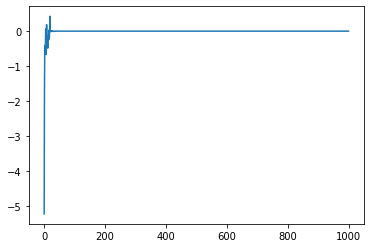

In [68]:
plt.plot(np.array(losses))
# plt.semilogy()


In [69]:
model.trainable_variables[0].numpy(), mu0

(array([0.7], dtype=float32), 0.7)

In [70]:
tf.nn.softplus(model.trainable_variables[1]).numpy(), sig0

(array([0.5], dtype=float32), 0.5)

In [71]:
tf.exp(model.trainable_variables[1]).numpy(), sig0

(array([0.6487213], dtype=float32), 0.5)

(array([0.00425642, 0.0237859 , 0.13495369, 0.42038451, 0.7378637 ,
        0.69680172, 0.36630288, 0.10065192, 0.01677532, 0.00200302]),
 array([-1.26387755, -0.8644813 , -0.46508504, -0.06568878,  0.33370748,
         0.73310374,  1.1325    ,  1.53189626,  1.93129252,  2.33068878,
         2.73008504]),
 <BarContainer object of 10 artists>)

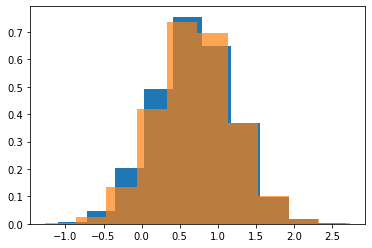

In [73]:
plt.hist(model.sample(10000).numpy().flatten(), density=True)
plt.hist(np.random.normal(mu0, sig0, 10000), density=True, alpha=0.7)


## Check different models

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([-0.24444312, -0.26448476, -0.39650986, -0.31899703, -0.23076516,
       -0.32249004], dtype=float32)>

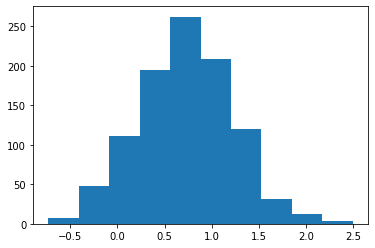

In [230]:

mu0, sig0 = np.float32(0.7), np.float32(0.5)
x0 = tf.constant(np.random.normal(mu0, sig0, 1000))
plt.hist(x0.numpy())

def loglik(w):
    loglik = tfd.Normal(mu0, sig0).log_prob(w)
    return loglik


w = tf.constant(np.random.uniform(0, 1, 6).astype(np.float32))
loglik(w)

In [231]:
import bbvi

In [285]:
def bbvi_train(model, mode, lr=0.001, nsamples=32, niter=5000):
    # Fit the model
    opt = tf.keras.optimizers.Adam(lr=lr)

    losses = []
    for epoch in range(niter):
        if epoch %500 == 0: print(epoch)
        if mode == 'score': elbo, grads = bbvi.bbvi(model, loglik, nsamples=nsamples)
        if mode == 'elbo': elbo, grads = bbvi.bbvi_elbo(model, loglik)
        if mode == 'reparam': elbo, grads = bbvi.bbvi_reparam(model, loglik)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        losses.append(elbo)
    return model, losses



def polyak_train(model, mode, lr=0.001, nsamples=32, niter=5000, momentum=0., gamma=0.5):
    # Fit the model
    opt = tf.keras.optimizers.SGD(lr=lr, momentum=momentum)

    epss, losses = [], []
    for epoch in range(niter):
        if epoch %500 == 0: print(epoch)
        if mode == 'full': elbo, loss, grads = polyakvi.polyakvi(model, loglik, nsamples=tf.constant(nsamples))
        if mode == 'score': elbo, loss, grads = polyakvi.polyakvi_score(model, loglik)
        gradnorm = (tf.linalg.global_norm(grads))
        eps = gamma*loss/gradnorm**2
#         print(eps, loss, gradnorm)
        opt.learning_rate = eps
        epss.append(eps)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        losses.append(elbo)
    return model, losses, epss



0
0


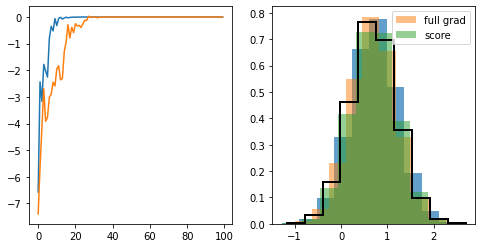

In [286]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[1].hist(np.random.normal(mu0, sig0, 10000), density=True, alpha=0.7)
ax[1].hist(np.random.normal(mu0, sig0, 10000), density=True, alpha=1, histtype='step', color='k', lw=2)

model = MF_Gaussian(1, scale=1) #VImeanfield(x0)
loglik(model.sample(32))
model, elbos, epss = polyak_train(model, 'full', niter=100, nsamples=32)
ax[0].plot(elbos)
ax[1].hist(model.sample(10000).numpy().flatten(), density=True, label='full grad', alpha=0.5)

model = MF_Gaussian(1, scale=1) #VImeanfield(x0)
loglik(model.sample(32))
model, elbos, epss = polyak_train(model, 'score', niter=100, nsamples=32)
ax[0].plot(elbos)
ax[1].hist(model.sample(10000).numpy().flatten(), density=True, label='score', alpha=0.5)

ax[1].legend()


0
0
creating graph
0
creating graph


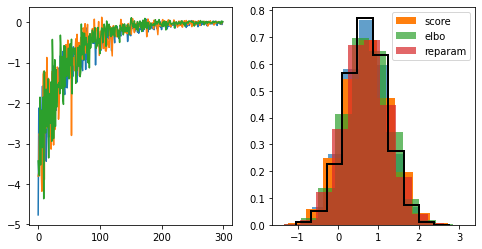

In [281]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[1].hist(np.random.normal(mu0, sig0, 10000), density=True, alpha=0.7)
ax[1].hist(np.random.normal(mu0, sig0, 10000), density=True, alpha=1, histtype='step', color='k', lw=2)

model = MF_Gaussian(1, scale=1) #VImeanfield(x0)
loglik(model.sample(32))
model, elbos_score = bbvi_train(model, 'score', lr=0.01, nsamples=64, niter=300)
ax[0].plot(elbos_score)
ax[1].hist(model.sample(10000).numpy().flatten(), density=True, label='score')

model = MF_Gaussian(1, scale=1) #VImeanfield(x0)
loglik(model.sample(32))
model, elbos = bbvi_train(model, 'elbo', lr=0.01, nsamples=64, niter=300)
ax[0].plot(elbos)
ax[1].hist(model.sample(10000).numpy().flatten(), density=True, alpha=0.7, label='elbo')

model = MF_Gaussian(1, scale=1) #VImeanfield(x0)
loglik(model.sample(32))
model, elbos = bbvi_train(model, 'reparam', lr=0.01, nsamples=32, niter=300)
ax[0].plot(elbos)
ax[1].hist(model.sample(10000).numpy().flatten(), density=True, alpha=0.7, label='reparam')
ax[1].legend()

plt.show()

In [237]:
model.trainable_variables[0], tf.nn.softplus(model.trainable_variables[1])

(<tf.Variable 'w_loc:0' shape=(1,) dtype=float32, numpy=array([0.69999987], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5000001], dtype=float32)>)

# Growth

In [15]:
g = np.load('/mnt/home/cmodi/Research/Projects/growth_func/growth.npy')


In [111]:
g.shape

(9, 256)

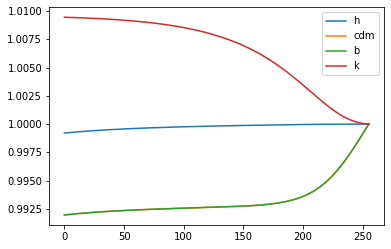

In [117]:
keys = ['0', 's8', 'h', 'cdm', 'b', 'k', 'w0', 'wa', 'ns']

for i in range(g.shape[0]):
    if np.allclose(g[i], g[0]): continue
    plt.plot(g[i]/g[0], label=keys[i])
plt.legend()

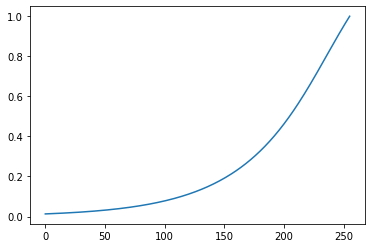

In [120]:
plt.plot(g[0])

In [7]:
np.load('/mnt/ceph/users/cmodi/growth_function/cosmo.npy')

array([[0.17798442, 0.02434786, 0.72504333],
       [0.35254731, 0.05295797, 0.55339072],
       [0.49807902, 0.055697  , 0.75830177],
       [0.23790145, 0.06388477, 0.62107172],
       [0.33360687, 0.04844797, 0.85464609],
       [0.39547103, 0.03132668, 0.88094562],
       [0.1085034 , 0.04041732, 0.67518317],
       [0.26686851, 0.02823755, 0.53638217],
       [0.4437393 , 0.03651444, 0.59551813],
       [0.20080602, 0.06668596, 0.80925821]])

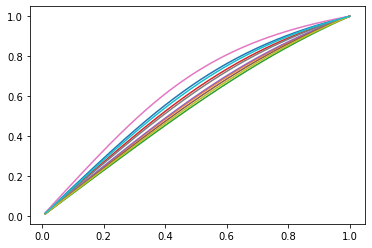

In [19]:
for i in range(10):
    f = np.load('/mnt/ceph/users/cmodi/growth_function/%d.npy'%i)
    plt.plot(1/(f[0]+1), f[1])

In [11]:
f

array([[9.90000000e+01, 9.72102604e+01, 9.54525526e+01, 9.37263031e+01,
        9.20309490e+01, 9.03659373e+01, 8.87307249e+01, 8.71247787e+01,
        8.55475746e+01, 8.39985985e+01, 8.24773449e+01, 8.09833179e+01,
        7.95160300e+01, 7.80750027e+01, 7.66597661e+01, 7.52698586e+01,
        7.39048268e+01, 7.25642254e+01, 7.12476174e+01, 6.99545732e+01,
        6.86846712e+01, 6.74374970e+01, 6.62126441e+01, 6.50097128e+01,
        6.38283108e+01, 6.26680529e+01, 6.15285606e+01, 6.04094622e+01,
        5.93103928e+01, 5.82309938e+01, 5.71709133e+01, 5.61298054e+01,
        5.51073307e+01, 5.41031556e+01, 5.31169527e+01, 5.21484001e+01,
        5.11971822e+01, 5.02629886e+01, 4.93455146e+01, 4.84444610e+01,
        4.75595339e+01, 4.66904447e+01, 4.58369100e+01, 4.49986513e+01,
        4.41753952e+01, 4.33668733e+01, 4.25728218e+01, 4.17929818e+01,
        4.10270989e+01, 4.02749233e+01, 3.95362096e+01, 3.88107171e+01,
        3.80982089e+01, 3.73984528e+01, 3.67112205e+01, 3.603628